## Sentiment Analysis of US Airline Twitter Dataset
### [Dataset](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment)

### 1) Text-Vectorization Techniques used:
- CountVectorizer
- TfidfVectorizer
- OneHotEncoding

### 2) ML Algorithms used:
- LogisticRegression
- Naive Bayes

## 1.Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
def create_df():
    df = pd.read_csv("/content/drive/MyDrive/data/Sentiment Analysis/US Airline Twitter Sentiment Analysis.csv", usecols=['text', 'airline_sentiment'])
    print(f"df shape: {df.shape}")

    #Convert sentiment values into 0 and 1
    df['airline_sentiment'] = df['airline_sentiment'].replace(to_replace=['negative', 'positive', 'neutral'], value=[0,1,2])
    return df

In [ ]:
df = create_df()
df.head(5)

df shape: (14640, 2)


,airline_sentiment,text
0,2,@VirginAmerica What @dhepburn said.
1,1,@VirginAmerica plus you've added commercials t...
2,2,@VirginAmerica I didn't today... Must mean I n...
3,0,@VirginAmerica it's really aggressive to blast...
4,0,@VirginAmerica and it's a really big bad thing...


### 1.2 Train Test Split

In [ ]:
def train_test_split(df):
    from sklearn.model_selection import train_test_split

    x_train, x_test, y_train, y_test = train_test_split(df['text'], df['airline_sentiment'], test_size=0.30, shuffle=True)
    print(f"x_train: {len(x_train)}")
    print(f"x_test: {len(x_test)}")
    print(f"y_train: {len(y_train)}")
    print(f"y_test: {len(y_test)}")
    return x_train, x_test, y_train, y_test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df)

x_train: 10248
x_test: 4392
y_train: 10248
y_test: 4392


## 2.Data Preprocessing

In [ ]:
def preprocess(data):
    import re #for regex removal
    import nltk
    nltk.download('punkt') #for tokenization
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords #for removing stopwords
    nltk.download('stopwords')
    stop_words = stopwords.words('english')
    for i in ["not", "no"]:
        stop_words.remove(i)
    from nltk.stem.wordnet import WordNetLemmatizer #for lemmatization
    nltk.download('omw-1.4')
    nltk.download('wordnet')
    lemmatizer = WordNetLemmatizer()
    nltk.download('averaged_perceptron_tagger')
    from nltk.tag import pos_tag
    from functools import reduce #concatenate words into sentence using reduce

    tweets = list()

    for line in data:

        #1. Removing URLS
        line = re.sub('http\S+', '', line).strip()
        line = re.sub('www\S+', '', line).strip()

        #2. Removing upper brackets to keep negative auxiliary verbs in text
        line = line.replace("'", "")

        #3. Removing symbols and numbers
        line = re.sub(r"[^a-zA-Z]+", ' ', line).strip()

        #4. Convert string to tokens, lowercase it & remove stop words
        tokens = word_tokenize(line)  #to convert a string to tokens
        tokens = [w.lower() for w in tokens if len(w)>1] #convert to lowercase
        tokens = [w for w in tokens if w not in stop_words] #remove stop words

        #5. Remove airline names tokens
        airlines = ['virginamerica', 'united', 'southwestair', 'delta', 'usairways', 'americanair', 'jetblue'] #[re.sub(r" ", '', name.lower()) for name in airline_names]
        words = [word if word not in airlines else 'airline' for word in tokens]

        #6. Reducing repeated characters
        words = [re.sub(r"(.)\1{2,}", r"\1"*2, word) for word in words]

        #7. Convert word to its base form
        lemmatized_tokens = []
        for word, tag in pos_tag(words):
            if tag.startswith('NN'):
                pos = 'n'
            elif tag.startswith('VB'):
                pos = 'v'
            else:
                pos = 'a'
            lemmatized_tokens.append(lemmatizer.lemmatize(word, pos))

        #8. Convert list of words into sentence
        str_sep = " "
        doc = str_sep.join(lemmatized_tokens)
        tweets.append(doc)

    return tweets

In [ ]:
preprocessed_tweets = preprocess(x_train)

for i in range(5):
    print(f"{i}-> {x_train.values[i]}\n preprocessed: {preprocessed_tweets[i]}\n")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


0-> @JetBlue No changes made. My son's pass printed on same conf #. Just mine not print after I expressed disapptment w/ JetBlue
 preprocessed: airline no change make son pass print conf mine not print expressed disapptment airline

1-> @JetBlue #FlyingItForward I'd fly to Port au Prince, Haiti to help with the on-going earthquake relief efforts. Still lots to do there!
 preprocessed: airline flyingitforward id fly port au prince haiti help go earthquake relief effort still lot

2-> @united that's fine. I'll take them.
 preprocessed: airline thats fine ill take

3-> @SouthwestAir ruined my Sunday. 3+ hours of delays out of DIA, now my bags are at the wrong airport. $35 to deliver them? Insult to injury.
 preprocessed: airline ruin sunday hour delay dia bag wrong airport deliver insult injury

4-> @united yes, a paper voucher that I got on January 26th 2015
 preprocessed: airline yes paper voucher get january th



## 3. Pipeline [official doc](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

#### 3.1. Text Feature Extraction
- OneHotEncoder [official doc](https://www.analyticsvidhya.com/blog/2021/07/bag-of-words-vs-tfidf-vectorization-a-hands-on-tutorial/)

- CountVectorizer [official doc](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

- TFIDFVectorizer [official doc](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

#### 3.2. Model Training

- Logistic Regression [official doc](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

- Naive Bayes [official doc](https://scikit-learn.org/stable/modules/naive_bayes.html)

#### 3.3. Performance Evaluation

In [ ]:
def train_test_models(x_train, x_test, y_train, y_test, preprocessed_tweets):
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.pipeline import Pipeline


    #________________Define models______________

    ohe_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), binary='true')
    cv_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1))
    tf_vectorizer = TfidfVectorizer(ngram_range=(1,1), sublinear_tf=True)
    lr_classifier = LogisticRegression(max_iter=500)
    nb_classifier = MultinomialNB(alpha=.7)


    #___________Define model pipelines______________

    # CountVectorizer with Linear Regression and Naive Bayes Classifiers
    pipeline_ohe_lr = Pipeline([
            ('vectorizer', ohe_vectorizer),
            ('classifier', lr_classifier)
        ])

    pipeline_ohe_nb = Pipeline([
            ('vectorizer', ohe_vectorizer),
            ('classifier', nb_classifier)
        ])

    pipeline_cv_lr = Pipeline([
            ('vectorizer', cv_vectorizer),
            ('classifier', lr_classifier)
        ])

    pipeline_cv_nb = Pipeline([
            ('vectorizer', cv_vectorizer),
            ('classifier', nb_classifier)
        ])

    # TFIDFVectorizer with Linear Regression and Naive Bayes Classifiers
    pipeline_tf_lr = Pipeline([
            ('vectorizer', tf_vectorizer),
            ('classifier', lr_classifier)
        ])

    pipeline_tf_nb = Pipeline([
            ('vectorizer', tf_vectorizer),
            ('classifier', nb_classifier)
        ])

    pipelines = [pipeline_ohe_lr, pipeline_ohe_nb, pipeline_cv_lr, pipeline_cv_nb,
                 pipeline_tf_lr, pipeline_tf_nb]

    pipeline_names = ['oneHotEncoder_logisticRegression', 'oneHotEncoder_naiveBayes', 'countVectorizer_logisticRegression', 'countVectorizer_naiveBayes',
                     'TFIDFvectorizer_logisticRegression', 'TFIDFvectorizer_naiveBayes']


    #___________Model Training______________

    for i,pipe in enumerate(pipelines):
        pipe.fit(preprocessed_tweets, y_train)
        #print(f"{pipeline_names[i]} unique words: {len(pipe['vectorizer'].get_feature_names_out())}")


    # ___________Model Testing______________

    from sklearn import metrics
    #dataframe to store models performance
    df_performance = pd.DataFrame(columns= ['model_name', 'test_accuracy',
                                            'precision', 'recall', 'f1_score', 'cf_matrix'])
    for i,pipe in enumerate(pipelines):
        y_pred = pipe.predict(x_test)
        new_row = {'model_name': pipeline_names[i],
                   'test_accuracy': round(float(metrics.accuracy_score(y_true=y_test, y_pred=y_pred)),2),
                   'precision': round(float(metrics.precision_score(y_true=y_test, y_pred=y_pred, average='macro')),2),
                   'recall': round(float(metrics.recall_score(y_true=y_test, y_pred=y_pred, average='macro')),2),
                   'f1_score': round(float(metrics.f1_score(y_true=y_test, y_pred=y_pred, average='macro')),2),
                   'cf_matrix': metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)}
        #print(f"{i}\n{new_row}")
        df_performance = pd.concat([df_performance, pd.DataFrame([new_row])])

    return df_performance

In [ ]:
df_models_performance = train_test_models(x_train, x_test, y_train, y_test, preprocessed_tweets)
df_models_performance.reset_index(drop=True)

,model_name,test_accuracy,precision,recall,f1_score,cf_matrix
0,oneHotEncoder_logisticRegression,0.74,0.69,0.65,0.65,"[[2432, 167, 144], [179, 512, 47], [470, 114, ..."
1,oneHotEncoder_naiveBayes,0.74,0.74,0.57,0.61,"[[2644, 33, 66], [342, 343, 53], [607, 48, 256]]"
2,countVectorizer_logisticRegression,0.74,0.69,0.65,0.65,"[[2428, 167, 148], [180, 510, 48], [469, 115, ..."
3,countVectorizer_naiveBayes,0.74,0.74,0.57,0.61,"[[2641, 32, 70], [340, 343, 55], [607, 48, 256]]"
4,TFIDFvectorizer_logisticRegression,0.76,0.74,0.61,0.65,"[[2597, 50, 96], [264, 412, 62], [552, 50, 309]]"
5,TFIDFvectorizer_naiveBayes,0.70,0.75,0.48,0.50,"[[2700, 7, 36], [512, 185, 41], [714, 22, 175]]"


## 6.Visualize performance of models

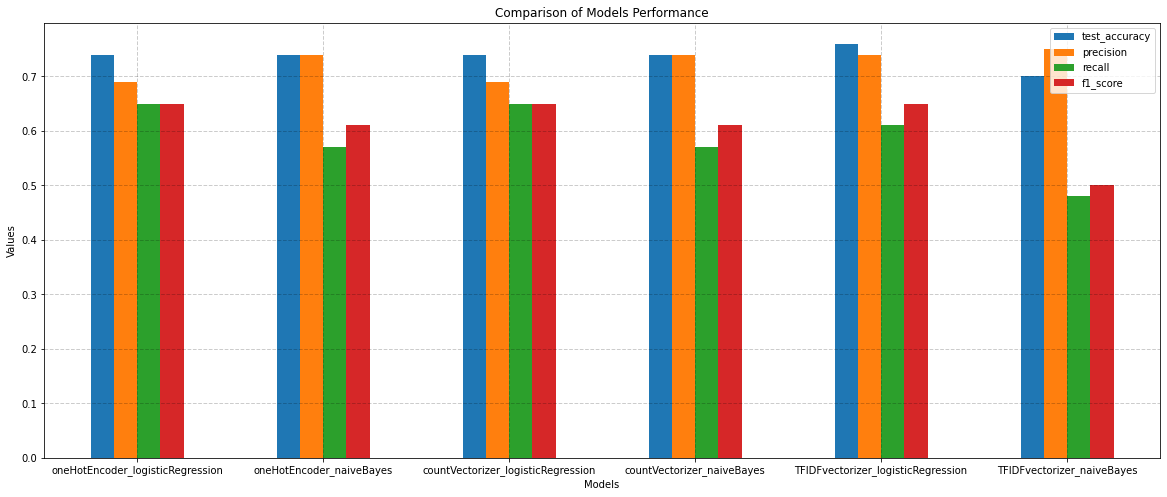

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_models_performance.plot.bar(x='model_name', rot=0, figsize=(20,8))
plt.title('Comparison of Models Performance')
plt.xlabel('Models')
plt.ylabel('Values')
#plt.xticks(rotation=35)
plt.grid(color = 'black', alpha = 0.2, linestyle = '--', linewidth = 1)
plt.show()

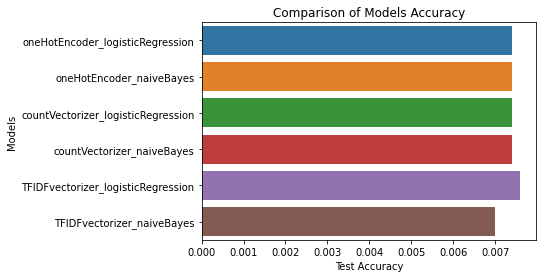

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#test accuracy*100
df_models_performance['test_accuracy'] = df_models_performance['test_accuracy']/100

sns.barplot(y = 'model_name', x = 'test_accuracy', data = df_models_performance, orient='h')
plt.title('Comparison of Models Accuracy')
plt.xlabel('Test Accuracy')
plt.ylabel('Models')
plt.show()

### BEST MODEL: TFIDFvectorizer_logisticRegression